## Accessing LLMs via GROQ or Ollama

Large Language Models (LLMs) can be accessed through various platforms. Two great options are **GROQ** and **Ollama**, each suited for different needs.

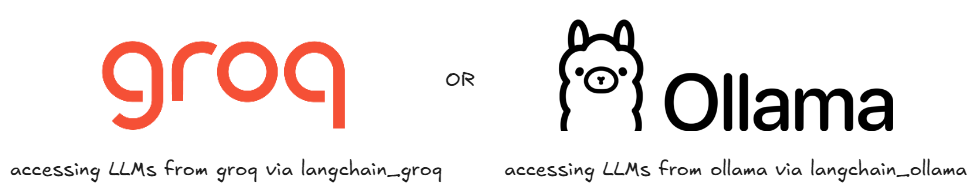

### GROQ
- **GROQ** is a free, cloud-based option ideal if you don't have an NVIDIA GPU or don't want to run models locally.
- It's optimized for high-speed AI inference, making it perfect for performance-driven applications.
- Use the `langchain_groq` package to integrate GROQ seamlessly into LangChain workflows.

### Ollama
- **Ollama** offers a developer-friendly, modern interface for hosting and interacting with LLMs.
- It simplifies model deployment and management, making it accessible to developers without extensive infrastructure setup.
- The `langchain_ollama` package enables easy integration with LangChain.

Both platforms allow you to interact with LLMs effortlessly while tailoring to your specific project requirements.


In [ ]:
# some pip installs
%pip install langchain_community langchain_core
# If you don't have them installed yet, install them based on what you are using
%pip install langchain_groq
#%pip install langchain_ollama

In [ ]:
from dotenv import load_dotenv
import os

# Load environment variables from the .env file
load_dotenv()

# Access the GROQ API key
GROQ_API_KEY = os.getenv("GROQ_API_KEY")

if GROQ_API_KEY:
    os.environ["GROQ_API_KEY"] = GROQ_API_KEY
    print("GROQ_API_KEY loaded successfully.")
else:
    print("Error: GROQ_API_KEY not found. Please check your .env file.")


There are [a few standard parameters](https://python.langchain.com/v0.2/docs/concepts/#chat-models) that we can set with chat models. Two of the most common are:

* `model`: the name of the model
* `temperature`: the sampling temperature

`Temperature` controls the randomness or creativity of the model's output where low temperature (close to 0) is more deterministic and focused outputs. This is good for tasks requiring accuracy or factual responses. High temperature (close to 1) is good for creative tasks or generating varied responses. 

In [ ]:
## Making an API Call to Groq/Ollama
# choose from a list of available models from the groq console / model playground
# for example, let's use llama-3.1-8b-instant here
from langchain_groq import ChatGroq
model = ChatGroq(model='llama-3.1-8b-instant', temperature=0.7)

Chat models in LangChain have a number of [default methods](https://python.langchain.com/v0.2/docs/concepts/#runnable-interface). For the most part, we'll be using:

* `stream`: stream back chunks of the response
* `invoke`: call the chain on an input

And, as mentioned, chat models take [messages](https://python.langchain.com/v0.2/docs/concepts/#messages) as input. Messages have a role (that describes who is saying the message) and a content property. We'll be talking a lot more about this later, but here let's just show the basics.

In [ ]:
from langchain_core.messages import HumanMessage

# Create a message
msg = HumanMessage(content="Hello world", name="Lance")

# Message list
messages = [msg]

# Invoke the model with a list of messages 
model.invoke(messages)

We get an `AIMessage` response. Also, note that we can just invoke a chat model with a string. When a string is passed in as input, it is converted to a `HumanMessage` and then passed to the underlying model.

In [ ]:
model.invoke("hello world")

The interface is consistent across all chat models and models are typically initialized once at the start up each notebooks. 

So, you can easily switch between models without changing the downstream code if you have strong preference for another provider like ollama.

## Search Tools

We'll also take a small peek at [Tavily](https://tavily.com/), which is a search engine optimized for LLMs and RAG (Retrieval Augmented Generation), aimed at efficient, quick, and persistent search results. It has a generous free tier to use.

Tavily enables your LLM to access the web just like the WebSearch feature in ChatGPT. This ensures that if you query something about real world events or knowledge outside scope of the LLM you will always get consistent and right results depending on the quality of data it uses from the web.

Visit the website to get access to it's API key.

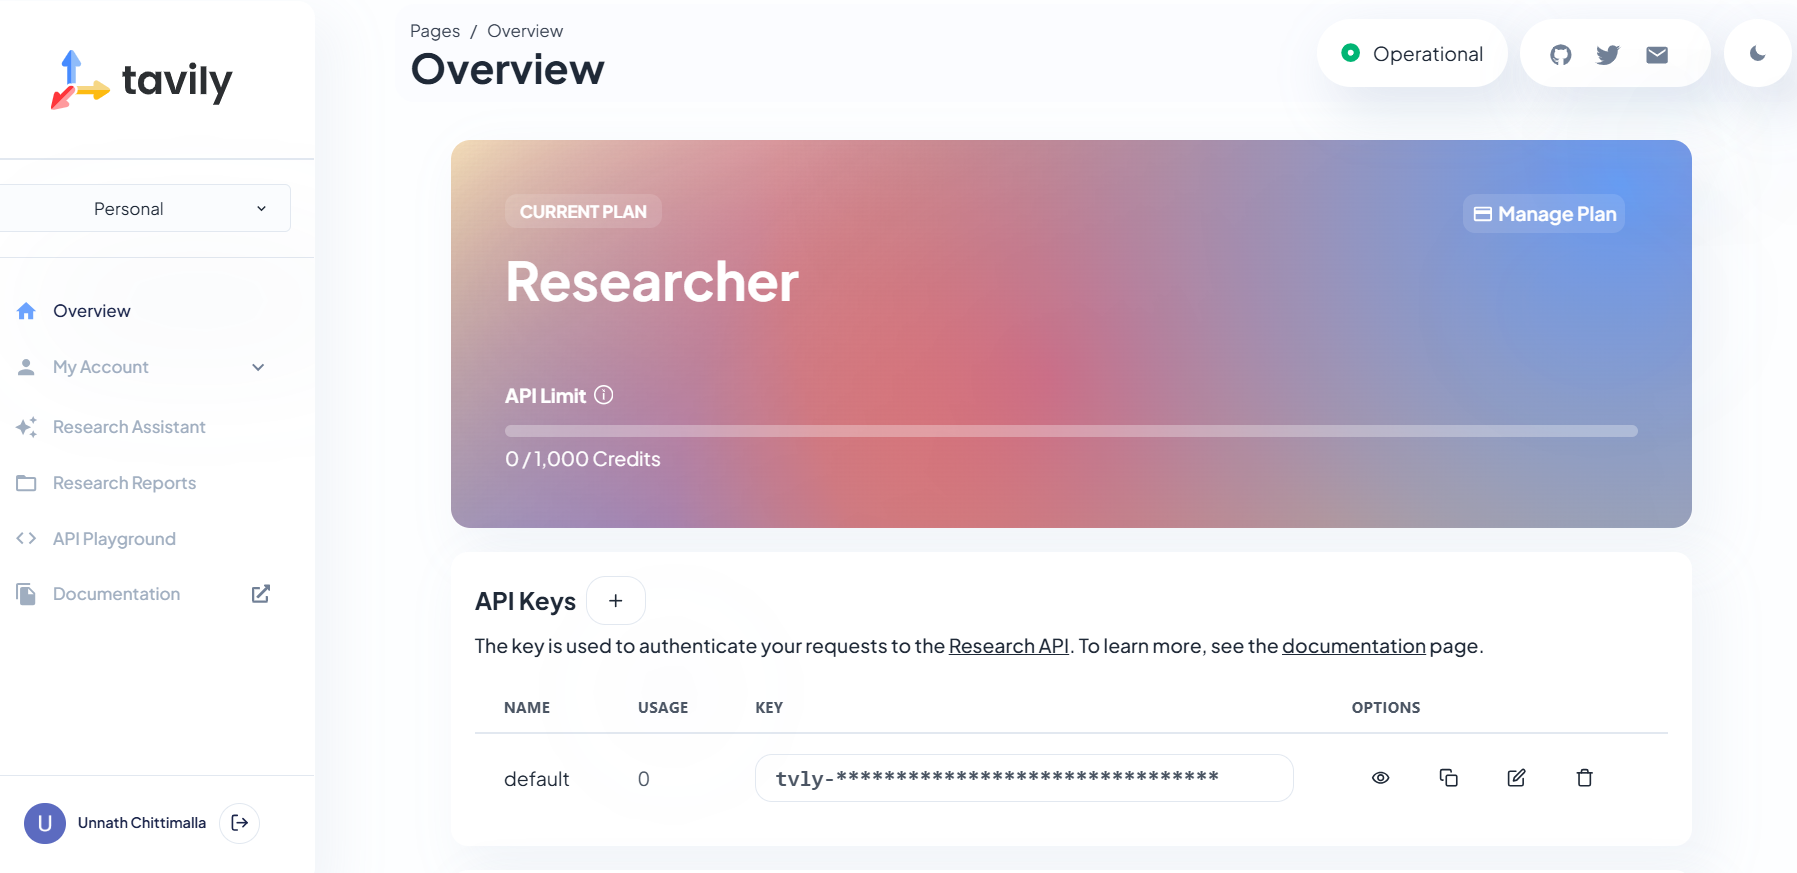

In [ ]:
import getpass
#paste in your tavily_api_key in the prompt after running this cell
var = "TAVILY_API_KEY"
os.environ[var] = getpass.getpass(f"{var}: ")

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)
search_docs = tavily_search.invoke("What are AI Agents?")

In [ ]:
search_docs